# Current Source Density Analysis
Current source density analysis (CSD) is a method of analysis of extracellular electric potential measurements recorded at multiple sites which produces estimates of current sources generating the measured potentials. Here, it is applied to our Ecephys Local Field Potential (LFP) measurements along a neuropixels probe to visualize how activity moves through the brain over time. In this notebook, we use **[Elephant](https://elephant.readthedocs.io/)**, an Electrophysiology Library for CSD Analysis {cite}`Yegenoglu2015`.

It is typically more useful to view CSD as an average across many stimulus trials for more visible results. In this notebook, stimulus times are used to average the LFP responses of several trials. To do this, the relevant stimulus times are selected from the `stimulus table`, then the LFP data is interpolated. Next, time windows of the trials are taken from the LFP data and averaged. Finally, the average LFP response is used as input to the CSD calculation.

### Environment Setup
⚠️**Note: If running on a new environment, run this cell once and then restart the kernel**⚠️

In [1]:
import warnings
warnings.filterwarnings('ignore')

try:
    from databook_utils.dandi_utils import dandi_download_open
except:
    !git clone https://github.com/AllenInstitute/openscope_databook.git
    %cd openscope_databook
    %pip install -e .

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import quantities as pq

from elephant.current_source_density import estimate_csd
from neo import AnalogSignal
from scipy import interpolate

### Downloading Ecephys File
For our data, we separate the LFP data for each probe into their own files since they are so large. The example file we use is from the Allen Institute's **Visual Coding - Neuropixels** dataset. To specify your own file to use, set `dandiset_id` and `dandi_filepath` to be the respective dandiset id and dandi filepath of the file you're interested in. When accessing an embargoed dataset, set `dandi_api_key` to be your DANDI API key.

In [3]:
dandiset_id = "000248"
dandi_stim_filepath = "sub-620334/sub-620334_ses-1189887297_ogen.nwb"
dandi_lfp_filepath = "sub-620334/sub-620334_ses-1189887297_probe-0_ecephys.nwb"
download_loc = "."
dandi_api_key = None

In [4]:
stim_io = dandi_download_open(dandiset_id, dandi_stim_filepath, download_loc, dandi_api_key=dandi_api_key)
stim_nwb = stim_io.read()
lfp_io = dandi_download_open(dandiset_id, dandi_lfp_filepath, download_loc, dandi_api_key=dandi_api_key)
lfp_nwb = lfp_io.read()

A newer version (0.67.2) of dandi/dandi-cli is available. You are using 0.61.2


File already exists
Opening file


c:\Users\carter.peene\Desktop\Projects\openscope_databook\databook_env\lib\site-packages\hdmf\utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.6.0 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
c:\Users\carter.peene\Desktop\Projects\openscope_databook\databook_env\lib\site-packages\hdmf\utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.3.0 because version 0.5.0 is already loaded.
  return func(args[0], **pargs)


File already exists
Opening file


### Reading LFP Data and Stimulus Data
Here, we read in the stimulus NWB file and the LFP NWB files. The LFP data is read from this file's probe data section. The `LFP` object contains a `data` array and a `timestamps` array which will be used.

In [5]:
lfp = lfp_nwb.acquisition["probe_0_lfp_data"]
print(lfp)

probe_0_lfp_data pynwb.ecephys.ElectricalSeries at 0x1711688555280
Fields:
  comments: no comments
  conversion: 1.0
  data: <HDF5 dataset "data": shape (11295871, 89), type "<f4">
  description: no description
  electrodes: electrodes <class 'hdmf.common.table.DynamicTableRegion'>
  interval: 1
  offset: 0.0
  resolution: -1.0
  timestamps: <HDF5 dataset "timestamps": shape (11295871,), type "<f8">
  timestamps_unit: seconds
  unit: volts



### Extracting Stimulus Times
First, you must take a stimulus table from your stimulus file. Since your stimulus table will be unique to your experiment, you'll have to use some ingenuity to extract the timestamps that are of interest to you. Below, the stimulus names of are displayed. Set `stim_name` to be the name that contains the associated stimulus table you want. Then we display the stimulus table. You can see that it contains the `start_time` of each stimulus event. Below, you can define `stim_select` to select individual rows of the table based on these properties. `stim_times` should be a list of timestamps.

In [6]:
stim_nwb.intervals.keys()

dict_keys(['ICkcfg0_presentations', 'ICkcfg1_presentations', 'ICwcfg0_presentations', 'ICwcfg1_presentations', 'RFCI_presentations', 'invalid_times', 'sizeCI_presentations', 'spontaneous_presentations'])

In [7]:
stim_name = "ICkcfg1_presentations"
stim_table = stim_nwb.intervals[stim_name]
stim_table[:10]

,start_time,stop_time,stimulus_name,stimulus_block,frame,stimulus_index,tags,timeseries
id,,,,,,,,
0,5226.83575,5227.23611,ICkcfg1,2.0,0.0,2.0,[stimulus_time_interval],"[(12103, 1, timestamps pynwb.base.TimeSeries a..."
1,5227.23611,5227.63645,ICkcfg1,2.0,0.0,2.0,[stimulus_time_interval],"[(12104, 1, timestamps pynwb.base.TimeSeries a..."
2,5227.63645,5228.03679,ICkcfg1,2.0,0.0,2.0,[stimulus_time_interval],"[(12105, 1, timestamps pynwb.base.TimeSeries a..."
3,5228.03679,5228.43712,ICkcfg1,2.0,0.0,2.0,[stimulus_time_interval],"[(12106, 1, timestamps pynwb.base.TimeSeries a..."
4,5228.43712,5228.83746,ICkcfg1,2.0,0.0,2.0,[stimulus_time_interval],"[(12107, 1, timestamps pynwb.base.TimeSeries a..."
5,5228.83746,5229.23780,ICkcfg1,2.0,0.0,2.0,[stimulus_time_interval],"[(12108, 1, timestamps pynwb.base.TimeSeries a..."
6,5229.23780,5229.63813,ICkcfg1,2.0,0.0,2.0,[stimulus_time_interval],"[(12109, 1, timestamps pynwb.base.TimeSeries a..."
7,5229.63813,5230.03852,ICkcfg1,2.0,0.0,2.0,[stimulus_time_interval],"[(12110, 1, timestamps pynwb.base.TimeSeries a..."
8,5230.03852,5230.43877,ICkcfg1,2.0,0.0,2.0,[stimulus_time_interval],"[(12111, 1, timestamps pynwb.base.TimeSeries a..."


In [8]:
### select start times from table that fit certain criteria here

stim_select = lambda row: True
all_stim_times = [float(row.start_time) for row in stim_table if stim_select(row)]
len(all_stim_times)

1380

### Selecting a Period
Oftentimes, the LFP data can be very large. Depending on the machine this analysis is performed on, there may not be enough memory for the following interpolation. This can be mitigated in two ways. Firstly, the `interp_hz` variable in the following section can be decreased. Otherwise, the analysis can be performed with some smaller period of time within the LFP data. If you wish to do this, set `period_start` and `period_end` to be reasonable times (in seconds) within the experiment to look at. Below are printed the first and last timestamps from the stimulus data and LFP data to inform this choice.

In [9]:
print(all_stim_times[0])
print(all_stim_times[-1])
print(lfp.timestamps[0])
print(lfp.timestamps[-1])

5226.83575
5778.89979
4.800154565552375
9041.485883872549


In [10]:
# period_start = lfp.timestamps[0]
period_start = 5227
# period_end = lfp.timestamps[-1]
period_end = 5777

In [11]:
# filter stim_timestamps to just timestamps within period
stim_times = np.array([ts for ts in all_stim_times if ts >= period_start and ts <= period_end])
if len(stim_times) == 0:
    raise ValueError("There are no stimulus timestamps in that period")

In [12]:
# find indices within lfp data that correspond to period bounds
period_start_idx, period_end_idx = np.searchsorted(lfp.timestamps, (period_start, period_end))

if period_start_idx == None or period_end_idx == None:
    raise ValueError("Period bounds not found within lfp data")

# get slice of LFP data corresponding to the period bounds
lfp_timestamps = lfp.timestamps[period_start_idx:period_end_idx]
lfp_data = lfp.data[period_start_idx:period_end_idx]

In [13]:
print(stim_times.shape)
print(lfp_timestamps.shape)
print(lfp_data.shape)

(1374,)
(687501,)
(687501, 89)


### LFP Interpolation
Because we cannot be certain that the LFP trace is at a perfectly regular sampling rate, we will interpolate it to be able to compare stimulus timestamps to their approximate LFP times. After you have a valid list of stimulus timestamps, you can generate a linearly-spaced timestamp array called `time_axis`, and interpolate the LFP data along it, making interpolated LFP data called `interp_lfp`. This should be a 2D array with dimensions `time` and `channel`, where channels are the different measurement channels along the probe. Here, the timestamps are interpolated to 250 Hertz, but you can change this by setting `interp_hz`.

In [14]:
interp_hz = 250

In [15]:
print(lfp_timestamps.shape)
print(lfp_data.shape)

(687501,)
(687501, 89)


In [16]:
# generate regularly-space x values and interpolate along it
time_axis = np.arange(lfp_timestamps[0], lfp_timestamps[-1], step=(1/interp_hz))
interp_lfp = []

# interpolate channel by channel to save RAM
for channel in range(lfp_data.shape[1]):
    f = interpolate.interp1d(lfp_timestamps, lfp_data[:,channel], axis=0, kind="nearest", fill_value="extrapolate")
    interp_lfp.append(f(time_axis))

interp_lfp = np.array(interp_lfp)

print(interp_lfp.shape)

(89, 137500)


### Getting Stimulus Time Windows
Now that you have your interpolated LFP data, you can use the stimulus times to identify the windows of time in the LFP data that exist around a stimulus event. Since the LFP data have been interpolated, we can easily translate timestamps to indices within the LFP trace array. Set `window_start_time` to be a negative number, representing the seconds before the stimulus event and `window_end_time` to be number of seconds afterward. Then the `windows` array will be generated as a set of slices of the `interp_lfp` trace by using `interp_hz` to convert seconds to array indices. These will be averaged out for each measurement channel, and a confidence interval will be calculated.

In [17]:
window_start_time = -0.05
window_end_time = 0.2

In [18]:
# validate window bounds
if window_start_time > 0:
    raise ValueError("start time must be non-positive number")
if window_end_time <= 0:
    raise ValueError("end time must be positive number")
    
# get event windows
windows = []
window_length = int((window_end_time-window_start_time) * interp_hz)

for stim_ts in stim_times:
    # convert time to index
    start_idx = int( (stim_ts + window_start_time - lfp_timestamps[0]) * interp_hz )
    end_idx = start_idx + window_length
 
    # bounds checking
    if start_idx < 0 or end_idx > interp_lfp.shape[1]:
        continue
        
    windows.append(interp_lfp[:,start_idx:end_idx])
    
if len(windows) == 0:
    raise ValueError("There are no windows for these timestamps")

windows = np.array(windows)
print(windows.shape)

(1373, 89, 62)


### Window Display Function
Here we define a function to display a stimulus response plot with axis labels and window time bounds. Below it is used to show a single LFP response window to the first stimulus timestamp. This function will be used to display the average LFP response to stimulus and the average CSD response to stimulus.

In [19]:
def display_response_window(window, start_time, end_time, vmin=None, vmax=None, title="", xlabel="", ylabel="", cbar_label=""):
    fig, ax = plt.subplots(figsize=(6,6))

    img = ax.imshow(window, 
                    extent=[start_time, end_time, 3840, 0], # probe is 3840 micrometers 
                    aspect="auto",
                    vmin=vmin,
                    vmax=vmax
                ) # set vmin and vmax here as needed

    # make dotted line at stimulus onset
    ax.plot([0,0],[0, 3840], ':', color='white', linewidth=1.0)

    cbar = fig.colorbar(img, shrink=0.5)
    cbar.set_label(cbar_label)

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

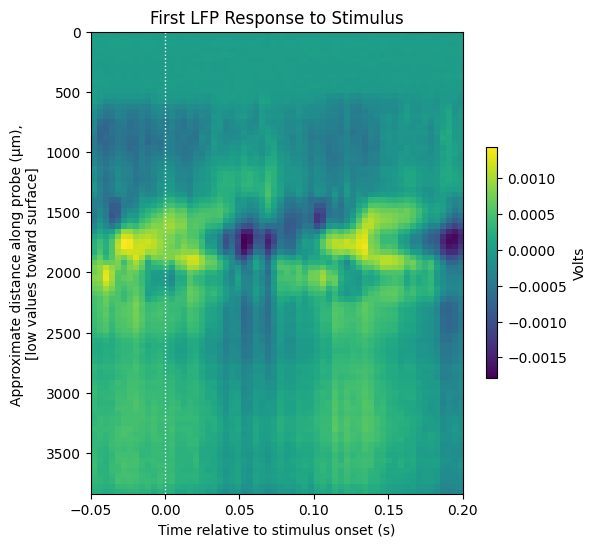

In [20]:
display_response_window(windows[0][::-1],
                        window_start_time,
                        window_end_time,
                        title="First LFP Response to Stimulus",
                        xlabel="Time relative to stimulus onset (s)",
                        ylabel="Approximate distance along probe (μm), \n[low values toward surface]",
                        cbar_label="Volts")

### Averaging LFP Response Windows
All the LFP response windows are averaged here to generate a view that illustrates how the LFP trace behaves before and after the onset of the stimulus events.

In [21]:
# get average of all windows
average_trace = np.average(windows, axis=0)
print(average_trace.shape)

(89, 62)


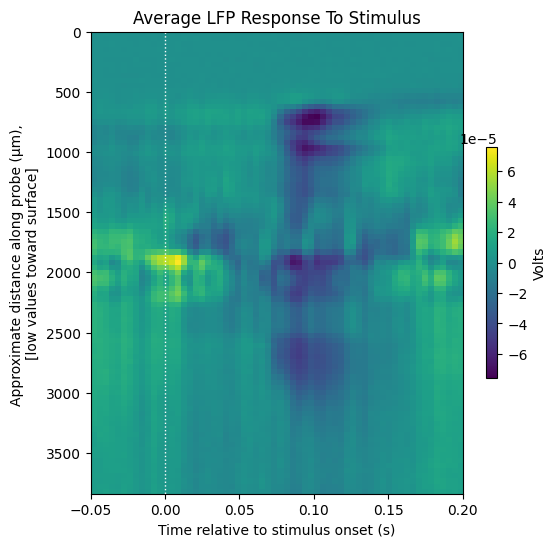

In [22]:
display_response_window(average_trace[::-1],
                        window_start_time,
                        window_end_time,
                        title="Average LFP Response To Stimulus",
                        xlabel="Time relative to stimulus onset (s)",
                        ylabel="Approximate distance along probe (μm), \n[low values toward surface]",
                        cbar_label="Volts")

### Using Elephant to Estimate CSD
**Elephant** takes input in the form of a **Neo** *AnalogSignal*. Before analysis, we create the *AnalogSignal* object with the LFP trace as input, in addition to the `hz` value as the `sampling_rate` of the data, and a list of numbers, `coords` representing the channels of the LFP data. After this, it is as simple as calling `estimate_csd`.

In [23]:
coords = [(elem,) for elem in range(average_trace.shape[0])]
neo_lfp = AnalogSignal(average_trace.transpose(), units="V", sampling_rate = interp_hz*pq.Hz)
neo_lfp.annotate(coordinates = coords * pq.mm)

In [24]:
# this takes a while
csd = np.array(estimate_csd(neo_lfp, method="KCSD1D"))
csd.shape

No lambda given, using defaults
Cross validating R (all lambda) : 0.23
R, lambda : 0.23 5.62341325190349e-20


(62, 100)

### Displaying Current Source Density
The current source density over time can be shown below with **matplotlib's** `imshow` method. The dark areas represent sinks and bright areas represent sources.

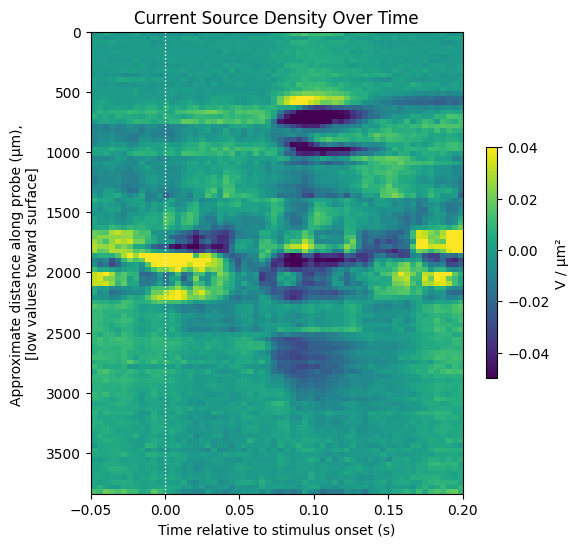

In [25]:
display_response_window(csd.transpose()[::-1],
                        window_start_time,
                        window_end_time,
                        title="Current Source Density Over Time",
                        xlabel="Time relative to stimulus onset (s)",
                        ylabel="Approximate distance along probe (μm), \n[low values toward surface]",
                        cbar_label="V / μm²",
                        vmin=-0.05,
                        vmax=0.04)